In [4]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import time
from typing import List
import pickle
import os 

os.chdir("/home/UANDES/n.grandas/pythontesis/pythontesis/basura/RESULTADOS/comparacionDeTiempo") # Esta linea hace que el cuaderno corra sobre el directorio deseado
device = "cuda" # Esta linea hace que el cuaderno se ejecute con la gpu de envidia
dtype = torch.float64 # Esta linea hace que el tipo de dato sean floats de 64 bits
estaResolviendo = False
buscandoLearningRate = False


class NeuralNetworkPrueba(nn.Module): # Acá se declara el tipo de red que se va a usar
    def __init__(self):
        super(NeuralNetworkPrueba, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

redDinamica = NeuralNetworkPrueba().to(device)

puntos = torch.linspace(0,7,20, device = device) #
puntos.requires_grad = True
perdidavar = 1e9
promAct = 0 
xsup = 7

def limitador(x):
    xint = x
    while (xint>xsup):
        xint -= xsup
    return xint
    

def actualizarPuntos():
    # Esta función va actualizar los puntos. Para mantener un balance entre puntos nuevos y puntos anteriores
    #  tambien va a cubir el espacio recorrido por puntos anteriores. Un objetivo de esta función es correr 
    # con un numero bajo de puntos
    global perdidavar,puntos,puntosCreados,promAct,c1,c2,sigma
    
    nuevosPuntos = puntos.detach().tolist()
    with torch.no_grad():
        promAct = limitador(promAct+c1/(perdidavar*len(puntos))**c2)  # acá se da el avance en promedio
    nuevoPunto = max(min(rd.normalvariate(promAct,sigma),xsup),0) # acá se da el avance como una distribución normal
    nuevosPuntos.append(nuevoPunto)    
    tamTensor = 120
    borra = 60
    anade = 50
    if len(nuevosPuntos)>tamTensor:
        for i in range(borra):
            indice = rd.randint(0,tamTensor-borra-2)
            nuevosPuntos.pop(indice)
        for i in range(anade):
            nuevosPuntos.append(rd.uniform(0,promAct))
    puntos = torch.tensor(nuevosPuntos,device = device)
    puntos.requires_grad = True

pesos = [1]*20
def actualizarPuntosConPesos():
     # Esta función va actualizar los puntos. Para mantener un balance entre puntos nuevos y puntos anteriores
    #  tambien va a cubir el espacio recorrido por puntos anteriores. Un objetivo de esta función es correr 
    # con un numero bajo de puntos
    global perdidavar,puntos,puntosCreados,promAct,c1,c2,sigma, pesos
    if isinstance(pesos,List):
        nuevosPesos = pesos.copy()
    else:
        nuevosPesos = pesos.detach().tolist()
    nuevosPuntos = puntos.detach().tolist()
    promAct = limitador(promAct+c1/(perdidavar/len(puntos))**c2)  # acá se da el avance en promedio
    nuevoPunto = max(min(rd.normalvariate(promAct,sigma),xsup),0) # acá se da el avance como una distribución normal
    nuevosPuntos.append(nuevoPunto) 
    nuevosPesos.append(1)   
    tamTensor = 20
    borra = 15
    anade = 10
    if len(nuevosPuntos)>tamTensor:
        for i in range(borra):
            indice = rd.randint(0,tamTensor-borra-2)
            nuevosPuntos.pop(indice)
            nuevosPesos.pop(indice)
        for i in range(anade):
            nuevosPuntos.append(rd.uniform(0,promAct))
            nuevosPesos.append(20)
    puntos = torch.tensor(nuevosPuntos,device = device)
    puntos.requires_grad = True
    pesos = nuevosPesos



In [5]:
class ultimaComparacion():
    def __init__(self,tiempos,perdidas,promedios,nombresito):
        self.tiempos = tiempos
        self.registrosPerdidasGlobales = perdidas
        self.registroPromedios = promedios
        self.nombre = nombresito
        self.frecuenciaSampleo = 200 # Sampleo cada 200 datos
        pass
    def anadirDato(self,tiempo,perdida):
        self.tiempos.append(tiempo)
        self.registrosPerdidasGlobales.append(perdida)

metodoTradicional = []
metodoUsado = []

puntosPrueba = torch.linspace(0,7,400,requires_grad=True)
varPerdidaCondicionParada = 1e9


def perdidaParaRevisar():
    global varPerdidaCondicionParada
    with torch.no_grad():
        suma = 0
        for j in puntosPrueba:
            i = torch.tensor([j],device=device)
            y = redDinamica(i)
            suma += torch.abs(y-torch.sin(j))
    varPerdidaCondicionParada = suma
    return suma

def perdidaConPesos():
    global perdidavar # esta variable guarda la perdida en una ubicación afuera de la función.
    x0 =  torch.tensor([0.0],device=device,requires_grad =True) # Ubicación en X de la primera condición de frontera
    # el 0.0 es importante para que pytorch lo identifique como un float.
    # acá el argumento device se usa para indicar que el vector debe guardarse en la memoria de la gpu
    # Acá el rgumento requires_grad = true se usa para indicar que la variable importa a la hora de la diferenciación 
    xPi = torch.linspace(3.14159/2,1,2,device = device) 
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True) # Ubicación en X se la segunda condición de frontera
    suma = 0
    contador = 0
    for j in puntos:
        i = torch.tensor([j],device=device,requires_grad =True) 
        # hay que meter el valor en X dentro de un vector para que pytorch lo tome como una operación de algebra lineal
        # lo anterior es necesario con la función nn.Sequential()
        y = redDinamica(i) 
        yprima=torch.autograd.grad(y,i,create_graph=True)[0]
        yprimaprima=torch.autograd.grad(yprima,i,create_graph=True)[0]
        suma+=pesos[contador]*(yprimaprima+y)**2
        contador +=1
    # Acá se usa alpha = 100
    suma+=100*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    perdidavar = suma
    return suma

def revisador():
    return varPerdidaCondicionParada<0.01*len(puntosPrueba)


perdida global:241.26336669921875
perdida local :4.437582015991211
promedios     :0.0002816849446389824


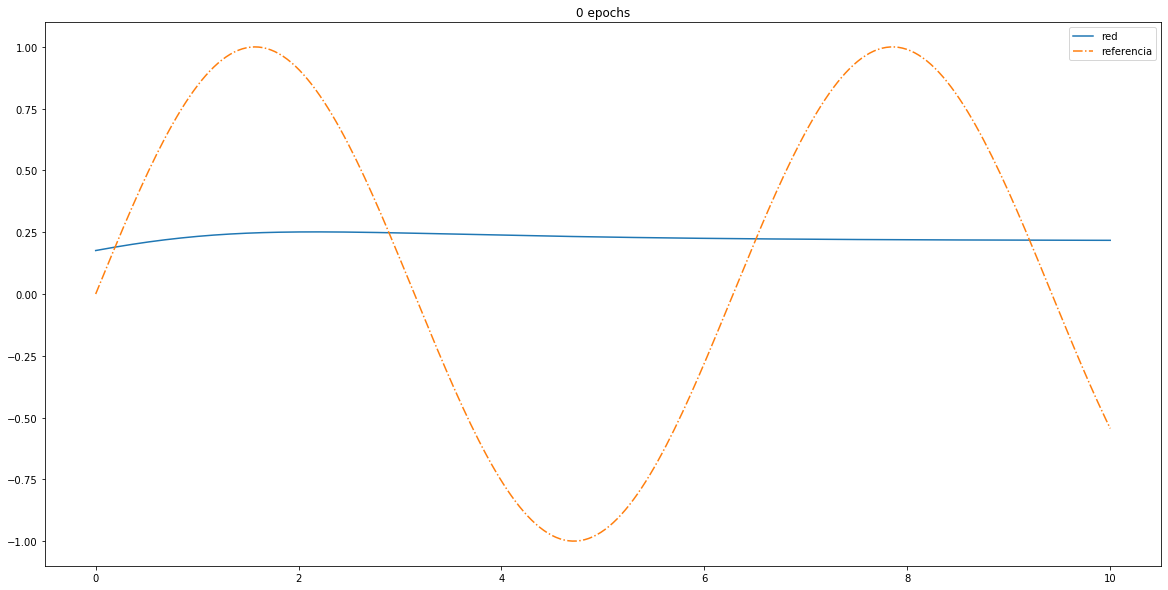

perdida global:251.4849853515625
perdida local :0.010210670530796051
promedios     :1.5202019214630127


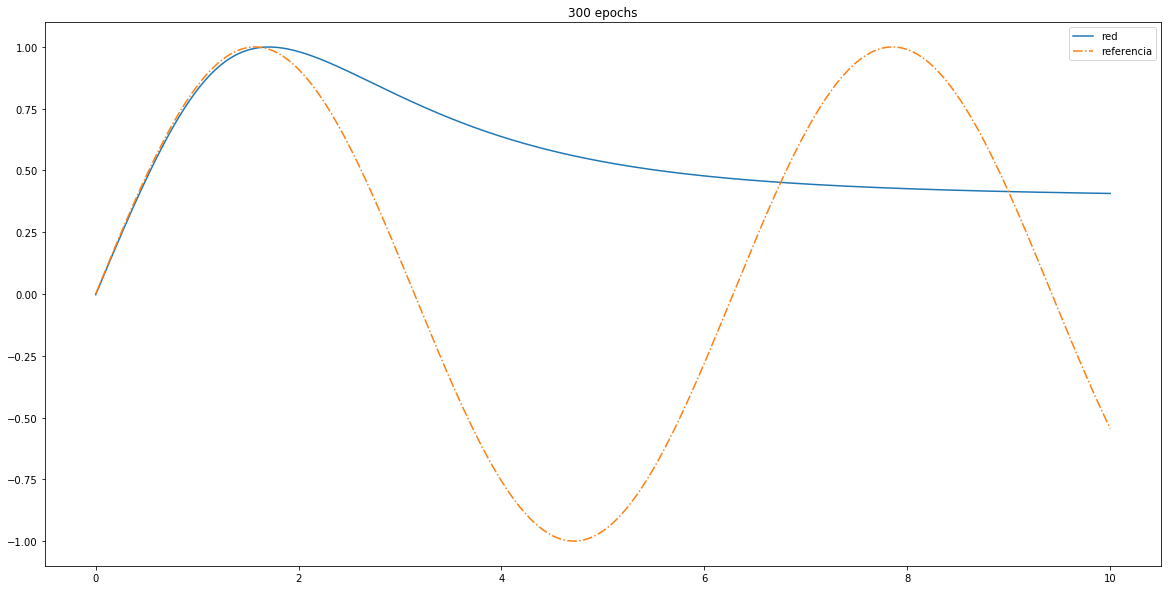

perdida global:150.8773193359375
perdida local :0.12786366045475006
promedios     :4.23621940612793


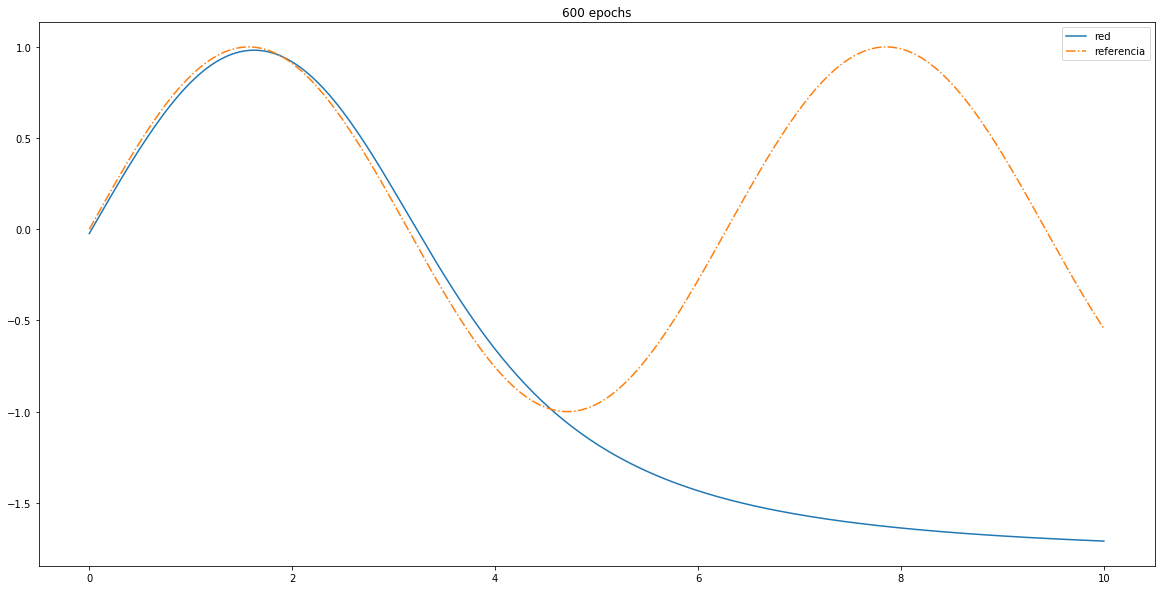

perdida global:114.85604858398438
perdida local :0.11824702471494675
promedios     :4.523502826690674


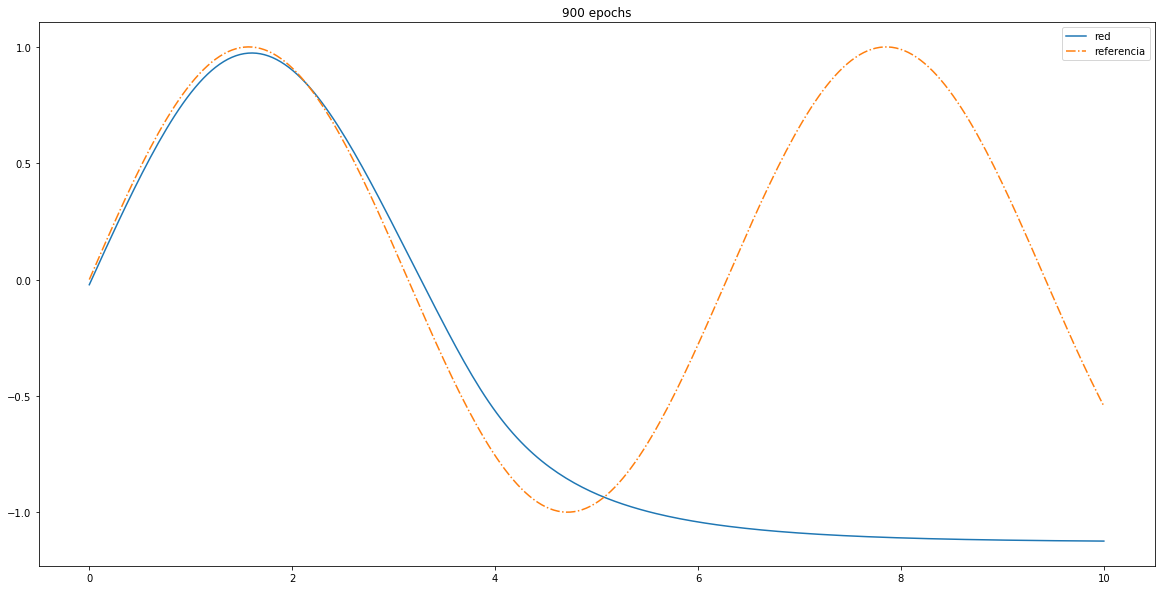

perdida global:41.63801193237305
perdida local :0.016167357563972473
promedios     :5.424753189086914


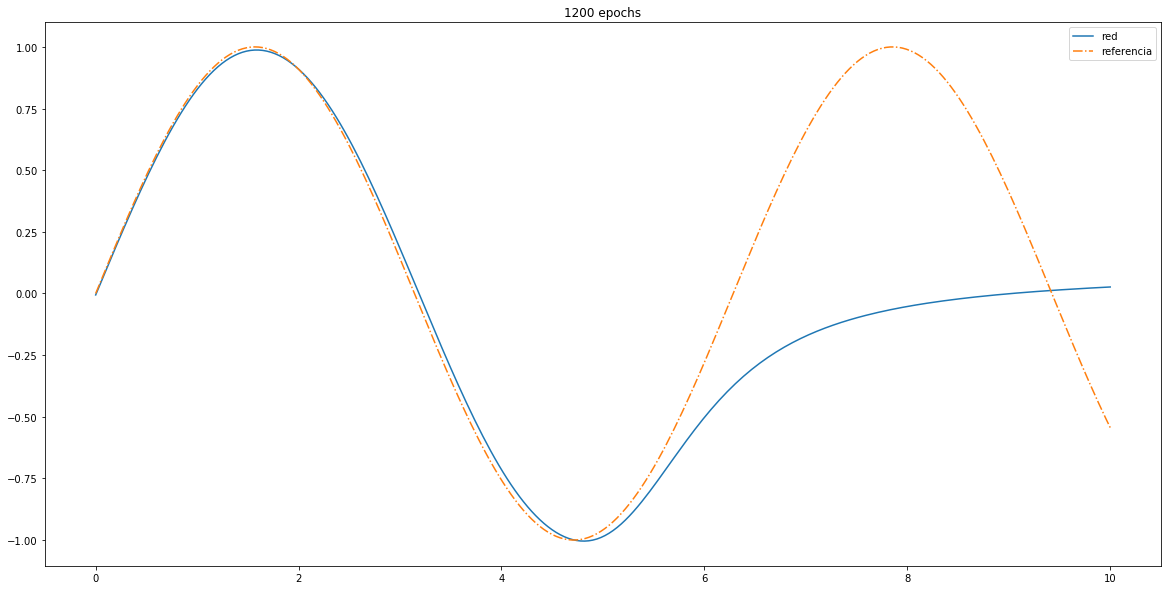

perdida global:25.775453567504883
perdida local :0.0004775805282406509
promedios     :6.921509265899658


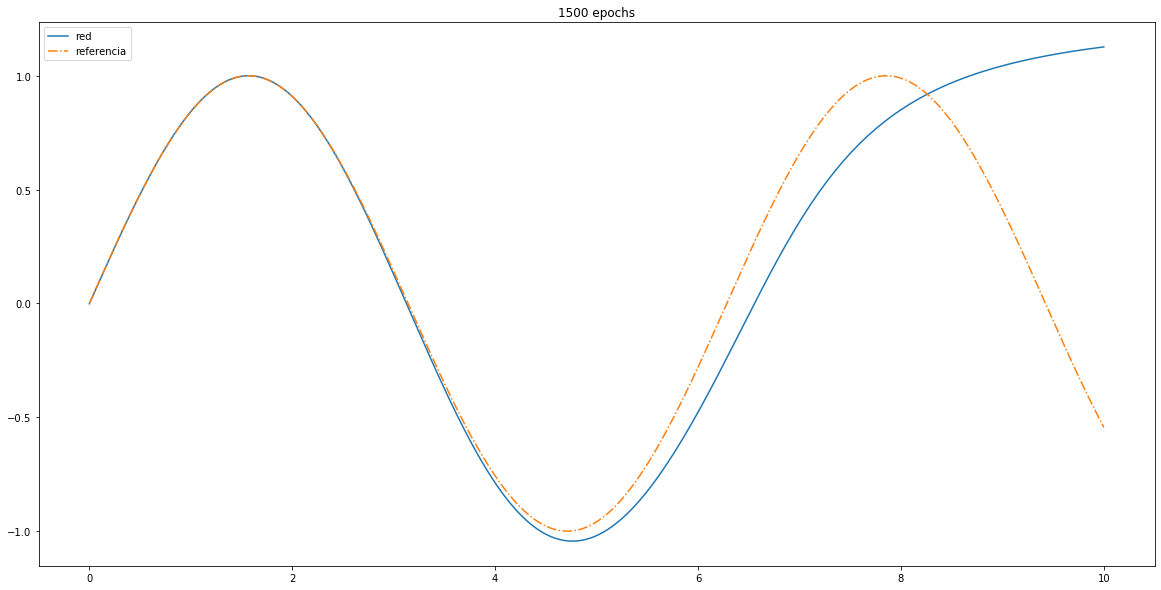

TERMINO EN 225.08610153198242 SEGUNDOS


<function BufferedWriter.close>

In [6]:
filename = "noUniformes.tar"
try:
    archivo = open(filename,"xb")
except:
    archivo = open(filename,"wb")

c2 = 1
c1 = 1e-3 #este coeficiente es para alentizar el avance con respecto a la función de perdiad
sigma = 0.2

for run in range(1):
    optimizer = torch.optim.Adam(redDinamica.parameters(), lr=1e-3)
    registro_perdida=[]
    registro_promedio=[]
    registro_tiempo = []
    tiempoInicial = time.time()
    i = 0
    termino = False
    while  not termino and tiempoInicial+3600*10>time.time() :
        # Compute prediction and loss
        loss = perdidaConPesos()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            actualizarPuntosConPesos()
        if i % 20 == 0:
            if True:
                registro_perdida.append(perdidaParaRevisar().item()/len(puntos))
                registro_promedio.append(promAct)
                registro_tiempo.append(time.time()-tiempoInicial)
            else:
                inutil = perdidaParaRevisar().item()/len(puntos)
            termino = revisador()
            
        if i % 300 == 0:
            print(f"perdida global:{varPerdidaCondicionParada.item()}")
            print(f"perdida local :{loss.item()/len(puntos)}")
            try:
                print(f"promedios     :{promAct.item()}")
            except:
                print(f"promedios     :{promAct}")
            plt.figure(figsize = (20,10))
            ygrafica = []
            puntosGrafica = torch.linspace(0,10,250)
            for j in puntosGrafica:
                ytemp=redDinamica(torch.tensor([j],device = device))
                ygrafica.append(ytemp.cpu().detach().numpy()[0])
                #ygrafica.append(ytemp.detach().numpy()[0])
            import numpy as np
            puntosGrafica = np.linspace(0,10,250)
            plt.plot(puntosGrafica,ygrafica,label = "red")
            plt.plot(puntosGrafica,np.sin(puntosGrafica),label = "referencia",LineStyle="-.")
            plt.legend()
            plt.title(f"{i} epochs")
            plt.show()
            if True:
                nombreParaGuardarRedIntermedia = f"estados/uniforme {i}, ronda {run}.tar"
                torch.save(redDinamica.state_dict(),nombreParaGuardarRedIntermedia)
        i+=1
    metodoTradicional.append(ultimaComparacion(
                                                registro_tiempo,
                                                registro_perdida,
                                                registro_promedio,
                                                f"uniforme {i}"
        ))
    
    print(f"TERMINO EN {time.time()-tiempoInicial} SEGUNDOS")
    nombreParaGuardarRedIntermedia = f"terminados/ronda {run}.tar"
    torch.save(redDinamica.state_dict(),nombreParaGuardarRedIntermedia)
    redDinamica = NeuralNetworkPrueba().to(device) 
pickle.dump(metodoTradicional,archivo)
archivo.close

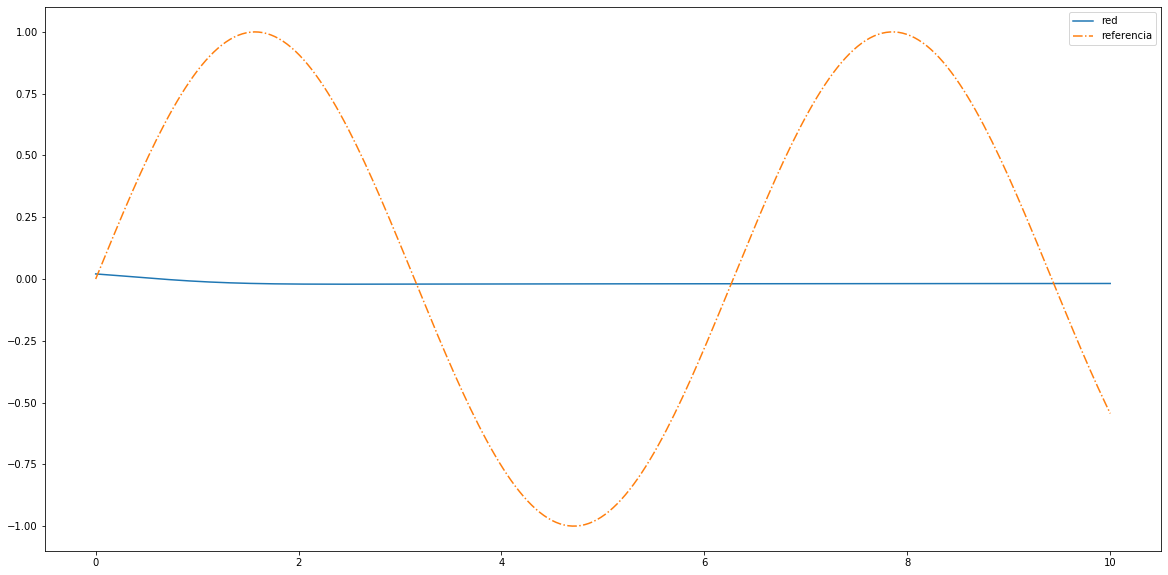

In [7]:
plt.figure(figsize = (20,10))
ygrafica = []
puntosGrafica = torch.linspace(0,10,250)
for i in puntosGrafica:
    ytemp=redDinamica(torch.tensor([i],device = device))
    ygrafica.append(ytemp.cpu().detach().numpy()[0])
    #ygrafica.append(ytemp.detach().numpy()[0])
import numpy as np
puntosGrafica = np.linspace(0,10,250)
plt.plot(puntosGrafica,ygrafica,label = "red")
plt.plot(puntosGrafica,np.sin(puntosGrafica),label = "referencia",LineStyle="-.")
plt.legend()

perdida global:241.64044189453125
perdida local :5.187870025634766
promedios     :5.587369441986084


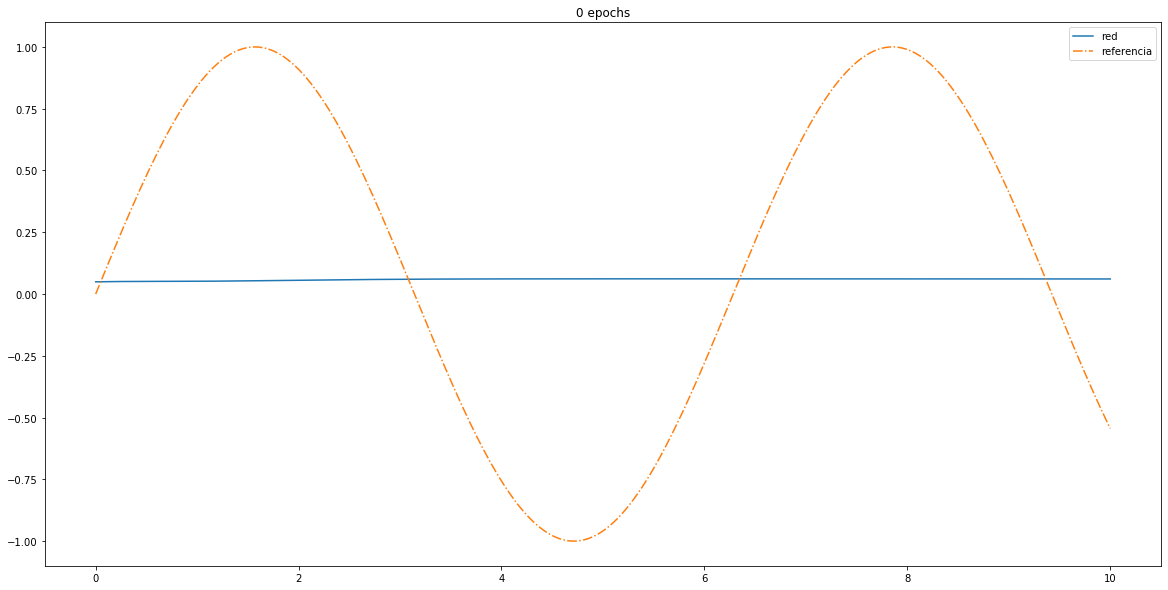

perdida global:130.73179626464844
perdida local :0.6194751262664795
promedios     :5.593085289001465


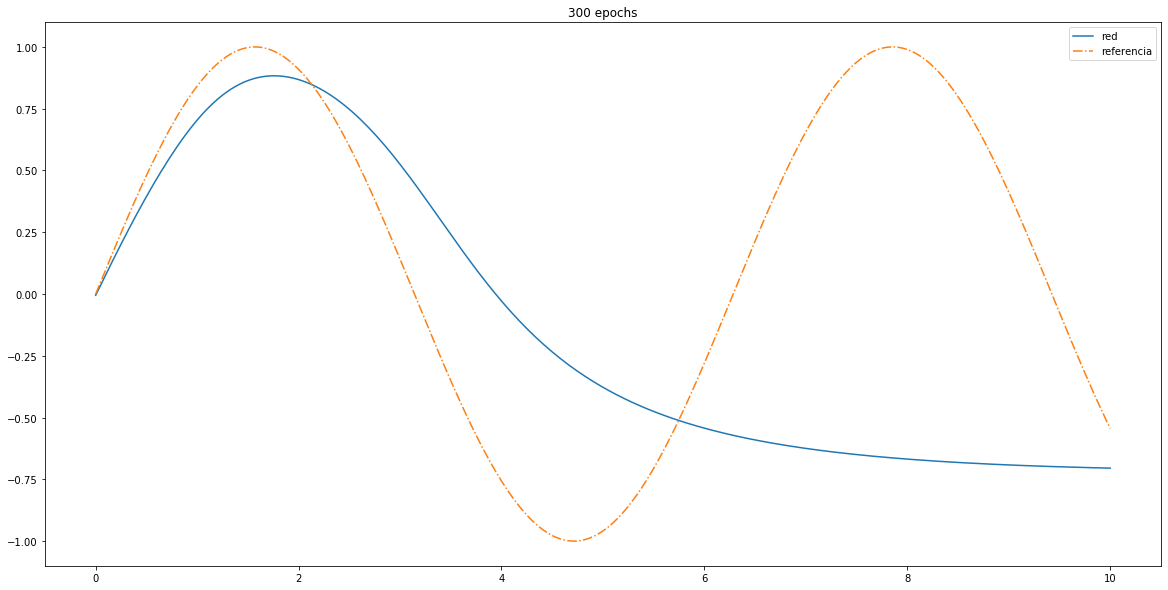

perdida global:163.59617614746094
perdida local :0.3085063695907593
promedios     :5.599544525146484


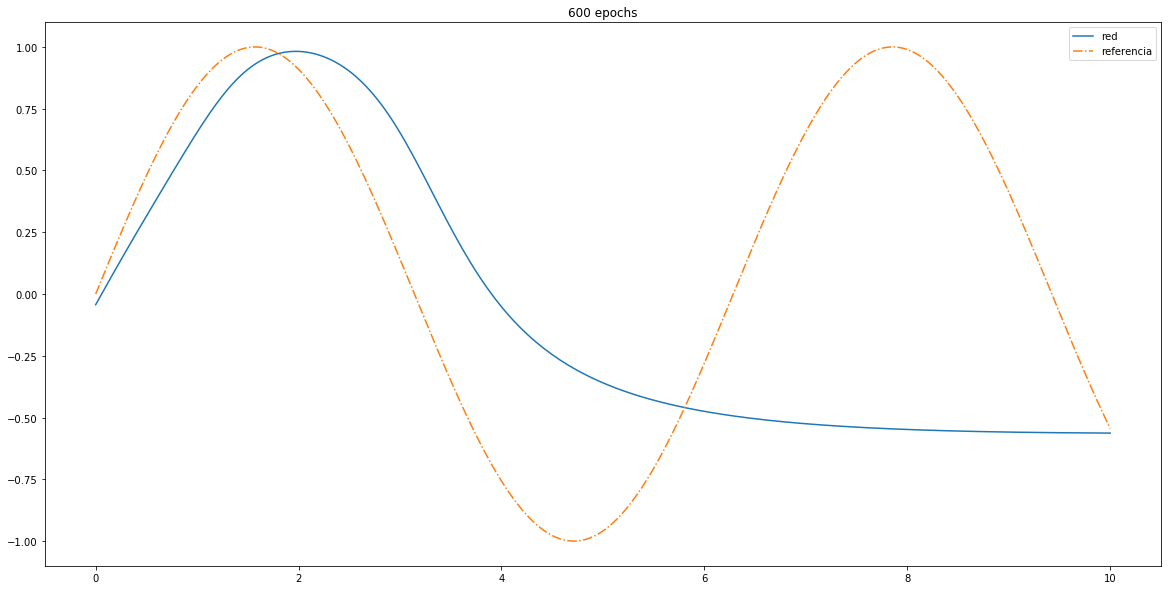

perdida global:134.9355926513672
perdida local :1.0408380508422852
promedios     :5.619091987609863


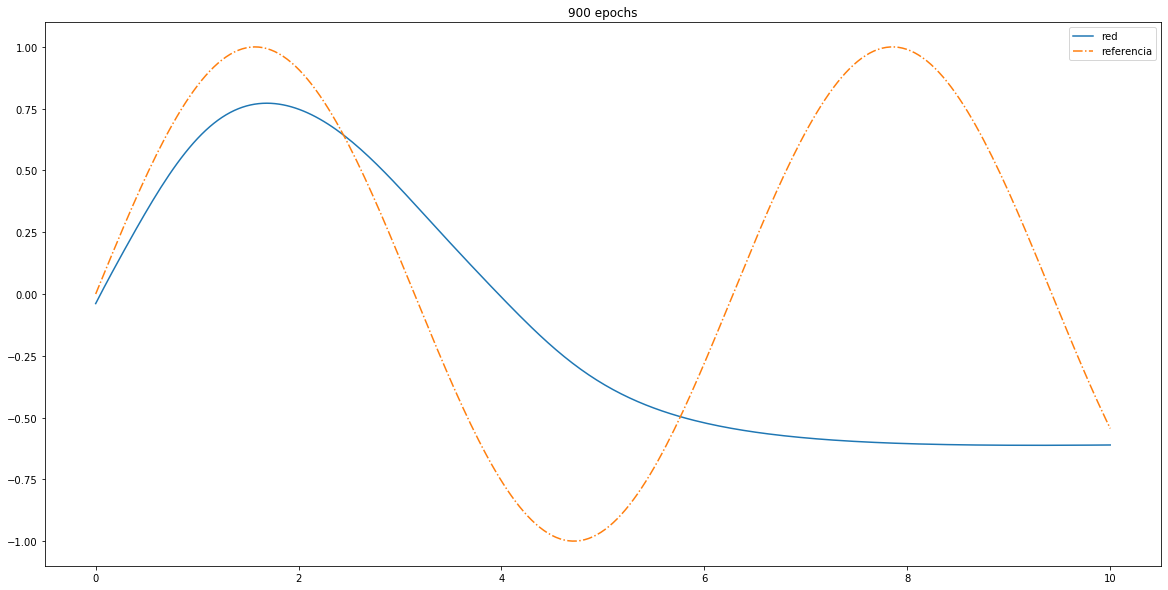

perdida global:125.8663558959961
perdida local :0.03989749252796173
promedios     :5.6655497550964355


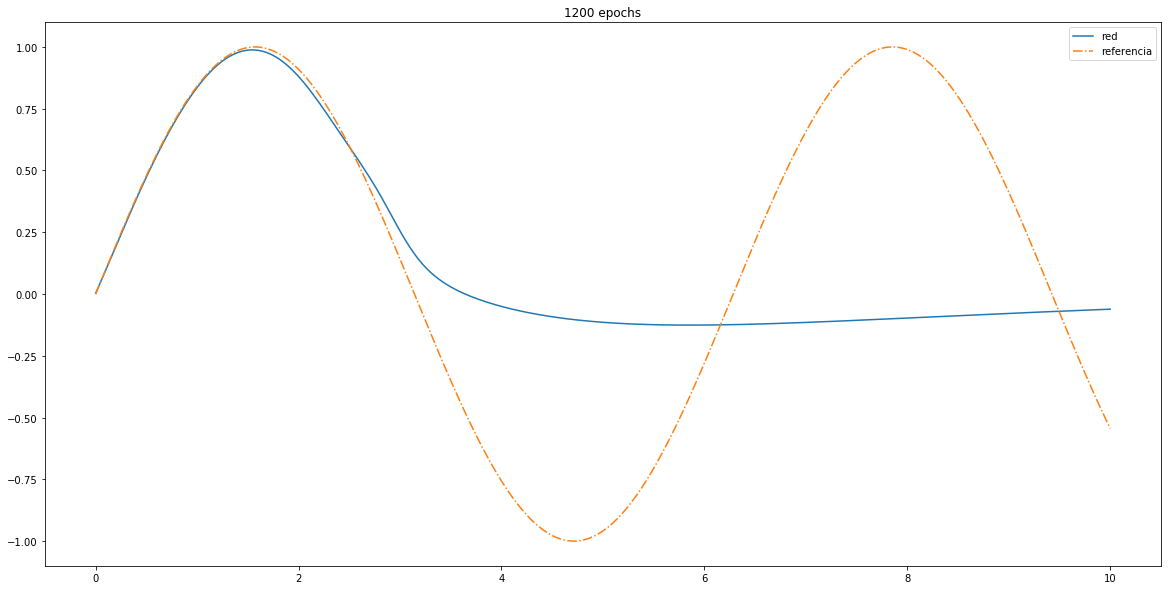

perdida global:157.61085510253906
perdida local :0.38975908756256106
promedios     :5.690220832824707


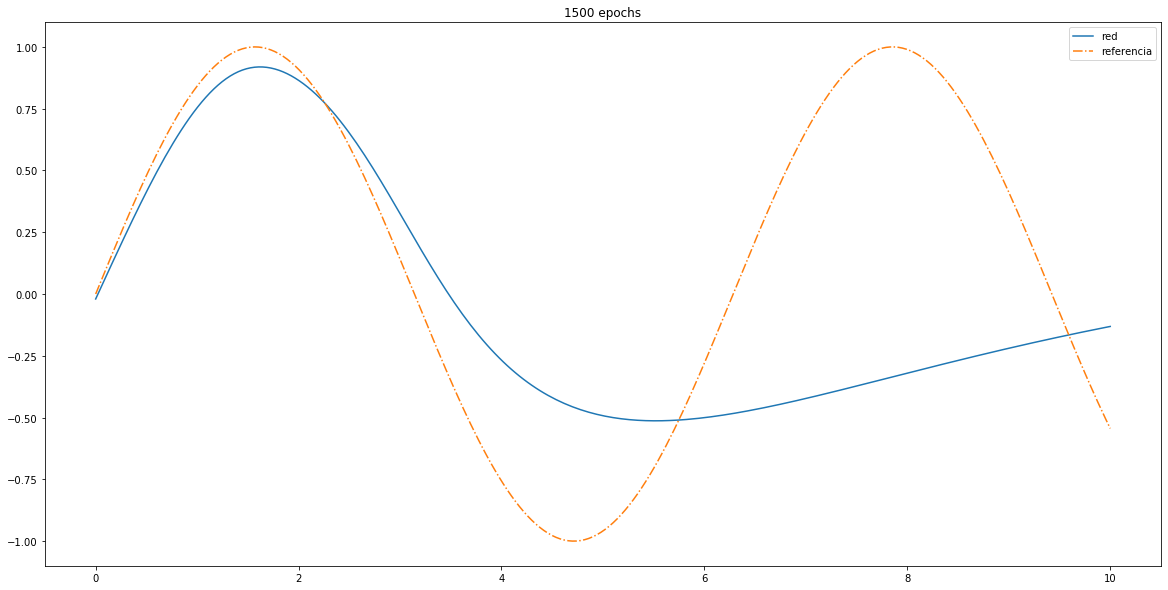

perdida global:20.364360809326172
perdida local :0.008987737447023391
promedios     :0.2090173065662384


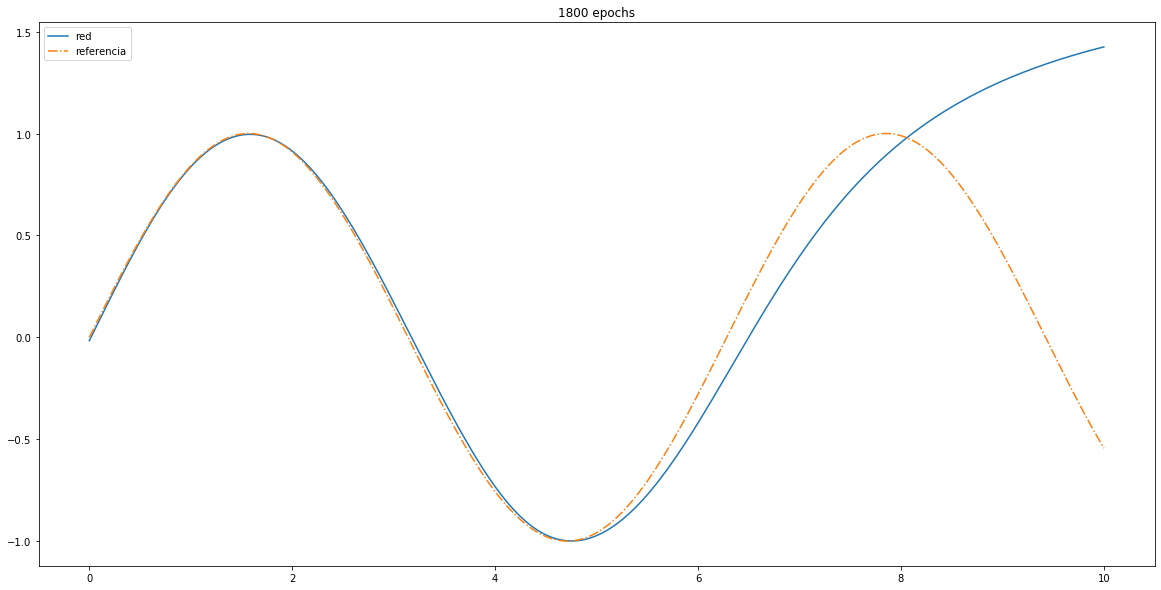

TERMINO EN 248.37432146072388 SEGUNDOS


<function BufferedWriter.close>

In [8]:
filename = "noUniformes.tar"
try:
    archivo = open(filename,"xb")
except:
    archivo = open(filename,"wb")

c2 = 1.2
c1 = 1e-4 #este coeficiente es para alentizar el avance con respecto a la función de perdiad
sigma = 0.2

for run in range(1):
    optimizer = torch.optim.Adam(redDinamica.parameters(), lr=1e-3)
    registro_perdida=[]
    registro_promedio=[]
    registro_tiempo = []
    tiempoInicial = time.time()
    i = 0
    termino = False
    while  not termino and tiempoInicial+3600*10>time.time() :
        # Compute prediction and loss
        loss = perdidaConPesos()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            actualizarPuntosConPesos()
        if i % 200 == 0:
            if True:
                registro_perdida.append(perdidaParaRevisar().item()/len(puntos))
                registro_promedio.append(promAct)
                registro_tiempo.append(time.time()-tiempoInicial)
            else:
                inutil = perdidaParaRevisar().item()/len(puntos)
            termino = revisador()
            
        if i % 300 == 0:
            print(f"perdida global:{varPerdidaCondicionParada.item()}")
            print(f"perdida local :{loss.item()/len(puntos)}")
            try:
                print(f"promedios     :{promAct.item()}")
            except:
                print(f"promedios     :{promAct}")
            plt.figure(figsize = (20,10))
            ygrafica = []
            puntosGrafica = torch.linspace(0,10,250)
            for j in puntosGrafica:
                ytemp=redDinamica(torch.tensor([j],device = device))
                ygrafica.append(ytemp.cpu().detach().numpy()[0])
                #ygrafica.append(ytemp.detach().numpy()[0])
            import numpy as np
            puntosGrafica = np.linspace(0,10,250)
            plt.plot(puntosGrafica,ygrafica,label = "red")
            plt.plot(puntosGrafica,np.sin(puntosGrafica),label = "referencia",LineStyle="-.")
            plt.legend()
            plt.title(f"{i} epochs")
            plt.show()
            if True:
                nombreParaGuardarRedIntermedia = f"estados/uniforme {i}, ronda {run}.tar"
                torch.save(redDinamica.state_dict(),nombreParaGuardarRedIntermedia)
        i+=1
    metodoTradicional.append(ultimaComparacion(
                                                registro_tiempo,
                                                registro_perdida,
                                                registro_promedio,
                                                f"uniforme {i}"
        ))
    
    print(f"TERMINO EN {time.time()-tiempoInicial} SEGUNDOS")
    nombreParaGuardarRedIntermedia = f"terminados/ronda {run}.tar"
    torch.save(redDinamica.state_dict(),nombreParaGuardarRedIntermedia)
    redDinamica = NeuralNetworkPrueba().to(device) 
pickle.dump(metodoTradicional,archivo)
archivo.close